<!-- # Indonesian Food Classification - Semi-Supervised Learning

---

## Summary

Notebook ini mengimplementasikan sistem klasifikasi makanan Indonesia menggunakan **Semi-Supervised Learning** dengan arsitektur **Lightweight MLP** yang mencapai akurasi **93%**. Model menggunakan kombinasi teknik advanced seperti self-training, SE-attention, dan class weighting untuk mengatasi keterbatasan data labeled.

### Key Features:
- SigLIP Vision Transformer (ekstraksi fitur)
- Advanced Test-Time Augmentation (TTA)
- Self-training dengan pseudo-labeling
- SE-Attention & Residual FFN
- Class weighting untuk mengatasi imbalanced data

--- -->

# Flow Diagram Pipeline

---

```
┌─────────────────────────────────────────────────────────────────────┐
│                    PIPELINE ARCHITECTURE                            │
└─────────────────────────────────────────────────────────────────────┘
```

### 1. Pra-pemrosesan Data
```
├── Deteksi & pembersihan gambar (noise/outlier)
├── Perbaikan orientasi EXIF
└── Resize ke 384×384 (konstan untuk ekstraksi fitur)
```

### 2. Ekstraksi Fitur
```
├── SigLIP Vision Transformer (ekstraktor utama)
├── Sistem cache fitur (simpan ke disk/feather/npy untuk cepat)
└── Normalisasi: Z-score lalu L2-normalize (untuk jarak/klasifikasi stabil)
```

### 3. Persiapan Seed Data (labeled)
```
├── Load CSV label terverifikasi
├── Fuzzy matching nama file → cocokkan image ↔ label
└── Buat peta kelas (class mapping) dan cek distribusi
```

### 4. Arsitektur Model
```
├── Blok SE-Attention (channel squeeze & excitation)
├── Residual Feed-Forward (FFN) layers untuk stabilitas pelatihan
└── Reduksi dimensi progresif sebelum head klasifikasi
```

### 5. Strategi Pelatihan
```
├── Pelatihan awal hanya dengan seed data 
├── Self-training loop — 3 putaran: inferensi → seleksi pseudo-label confident → retrain
└── Pelatihan akhir menggunakan semua data (seed + pseudo)
```

### 6. Inferensi & Evaluasi
```
├── Ekstraksi fitur untuk test set (pakai pipeline yang sama)
├── Prediksi model
└── Buat submission (format CSV) 
```

---

# SECTION 1: Setup & Konfigurasi

---

## 1.1 Import Libraries

In [29]:
import os, gc, json, pickle, warnings, shutil, re
from pathlib import Path
from collections import Counter, defaultdict
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as T
import timm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image, ImageOps
from torch.cuda.amp import autocast
warnings.filterwarnings("ignore")

## 1.2 Konfigurasi Global

In [30]:
class CFG:
    SEED = 42
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    DATA_ROOT = "/kaggle/input/data-mining-action-2025"
    TRAIN_DIR = os.path.join(DATA_ROOT, "train", "train")
    TEST_DIR = os.path.join(DATA_ROOT, "test", "test")
    WORKDIR = "/kaggle/working"
    CLEAN_DIR = os.path.join(WORKDIR, "train_clean")
    LABELED_CSV = "/kaggle/input/labeled-action/gabungan_label.csv"
    SUBMISSION = os.path.join("/kaggle/working", "submission.csv")
    IMG_SIZE = 384
    BATCH = 64
    SIGLIP_MODEL = "vit_so400m_patch14_siglip_384"

    PSEUDO_EPOCHS = 15
    PSEUDO_LR = 6e-4
    CONF_THRESH = 0.92      
    MIN_CONF_THRESH = 0.85  
    MAX_PER_CLASS = 250

    EPOCHS = 45
    LR = 1e-3
    DROPOUT = 0.55          
    LABEL_SMOOTH = 0.1
    EARLY_STOP_PATIENCE = 8

    WEAK_CLASSES_V2 = {
        "Ayam Betutu": 1, "Sate Padang": 1.3, "Ayam Bakar": 1,
        "Ayam Goreng": 1.3, "Sate Madura": 1
    }

    AUTO_LABEL_CSV = os.path.join(WORKDIR, "auto_labels.csv")
    SORTED_DIR = os.path.join(WORKDIR, "train_sorted")

## 1.3 Seed and Utility Functions

In [31]:
def seed_everything(seed):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def cleanup():
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()

def ensure_dir(p): os.makedirs(p, exist_ok=True)

seed_everything(CFG.SEED)

# SECTION 2: Data Preparation

---

## 2.1 Image Cleaning & Noise Detection

Folder clean sudah ada, skip cleaning.
Loaded removed list: 160 files
Menampilkan 3 sampel gambar yang dihapus:


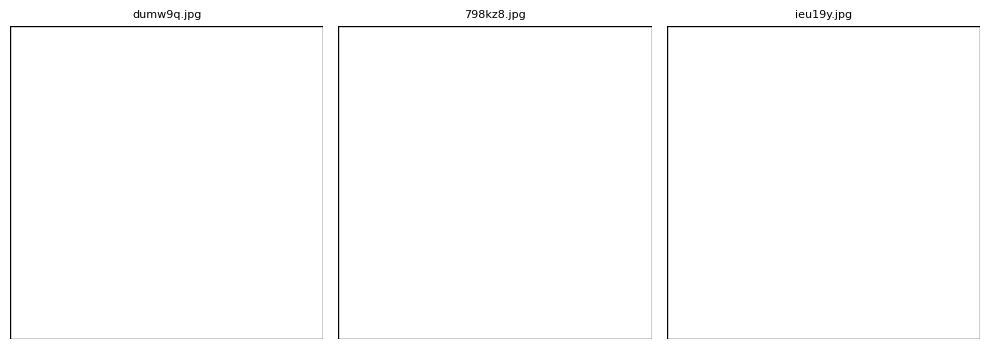

In [32]:
removed_json = Path("removed.json")
removed_samples = []

def is_noise(img: Image.Image) -> bool:
    arr = np.asarray(img)
    if arr.size == 0:
        return True
    if len(arr.shape) == 3:
        gray = np.dot(arr[...,:3], [0.2989, 0.5870, 0.1140])
    else:
        gray = arr
    white_ratio = (arr > 250).mean()
    mean, std = arr.mean(), arr.std()
    gy, gx = np.gradient(gray.astype(np.float32))
    edge = (np.abs(gx) + np.abs(gy)).mean()
    return (white_ratio > 0.98 and std < 3.0 and edge < 0.5)

def clean_images():
    global removed_samples
    clean_dir = Path(CFG.CLEAN_DIR)
    train_dir = Path(CFG.TRAIN_DIR)
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp", ".jfif"}

    if clean_dir.exists() and len(list(clean_dir.rglob("*"))) > 100:
        print("Folder clean sudah ada, skip cleaning.")

        if removed_json.exists():
            with open(removed_json, "r") as f:
                removed_samples = json.load(f)
            print(f"Loaded removed list: {len(removed_samples)} files")
        else:
            print("removed.json tidak ditemukan, tidak ada data gambar terhapus.")
        return

    shutil.rmtree(clean_dir, ignore_errors=True)
    clean_dir.mkdir(parents=True, exist_ok=True)

    paths = [p for p in train_dir.rglob("*") if p.suffix.lower() in exts]
    kept = 0

    for p in tqdm(paths, desc="Cleaning"):
        try:
            img = Image.open(p).convert("RGB")
            img = ImageOps.exif_transpose(img).resize((CFG.IMG_SIZE, CFG.IMG_SIZE), Image.LANCZOS)

            if not is_noise(img):
                rel = p.relative_to(train_dir)
                dst = clean_dir / rel
                dst.parent.mkdir(parents=True, exist_ok=True)
                img.save(dst, quality=95, optimize=True)
                kept += 1
            else:
                removed_samples.append(str(p))
        except:
            removed_samples.append(str(p))

    with open("removed.json", "w") as f:
        json.dump(removed_samples, f)

    print(f"Cleaning selesai. Kept: {kept}/{len(paths)}")
    print(f"Removed: {len(removed_samples)} gambar")

import matplotlib.patches as patches

def show_removed_samples():
    global removed_samples

    if not removed_samples and removed_json.exists():
        with open(removed_json, "r") as f:
            removed_samples = json.load(f)

    n_show = min(3, len(removed_samples))
    if n_show == 0:
        print("Tidak ada gambar yang dihapus.")
        return

    print(f"Menampilkan {n_show} sampel gambar yang dihapus:")
    sampled = removed_samples[:n_show]

    plt.figure(figsize=(10, 4))
    for i, path in enumerate(sampled):
        try:
            img = Image.open(path)
            ax = plt.subplot(1, 3, i + 1)
            ax.imshow(img)
            ax.set_title(Path(path).name, fontsize=8)
            ax.axis('off')

            rect = patches.Rectangle(
                (0, 0), 1, 1,
                transform=ax.transAxes,
                linewidth=1,
                edgecolor='black',
                facecolor='none'
            )
            ax.add_patch(rect)

        except:
            pass

    plt.tight_layout()
    plt.show()


clean_images()
show_removed_samples()

## 2.2 Dataset & Transform

In [33]:
transform_base = T.Compose([
    T.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE), interpolation=T.InterpolationMode.LANCZOS),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class ImgDS(Dataset):
    def __init__(self, root, transform=None):
        self.root = Path(root)
        exts = {".jpg",".jpeg",".png",".bmp",".webp",".jfif"}
        self.paths = sorted([p for p in self.root.rglob("*") if p.suffix.lower() in exts])
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        p = self.paths[i]
        try:
            img = Image.open(p).convert("RGB")
            img = ImageOps.exif_transpose(img)
            if self.transform: img = self.transform(img)
            rel = str(p.relative_to(self.root)).replace("\\", "/")
            return img, rel
        except:
            dummy = torch.zeros(3, CFG.IMG_SIZE, CFG.IMG_SIZE)
            rel = str(p.relative_to(self.root)).replace("\\", "/")
            return dummy, rel

# SECTION 3: Feature Extraction

---

## 3.1 SigLIP ViT-SO400M Extractor

In [34]:
def feature_cache_name(train=True):
    prefix = "train" if train else "test"
    return os.path.join(CFG.WORKDIR, f"{prefix}_feats_siglip384_norm.npz")

def extract_features_from_dir(dir_path, train=True):
    cache_path = feature_cache_name(train)
    if os.path.exists(cache_path):
        print(f"Loading cached features: {cache_path}")
        data = np.load(cache_path)
        return data['features'], data['names'].tolist()
    
    print(f"Extracting features from {dir_path}...")
    ds = ImgDS(dir_path, transform=transform_base)
    dl = DataLoader(ds, batch_size=CFG.BATCH, shuffle=False, num_workers=4, pin_memory=True)
    model = timm.create_model(CFG.SIGLIP_MODEL, pretrained=True, num_classes=0, global_pool='avg')
    model.eval().to(CFG.DEVICE)
    
    feats, names = [], []
    with torch.no_grad():
        for x, n in tqdm(dl, desc="Extract"):
            with autocast():
                f = model(x.to(CFG.DEVICE))
            feats.append(f.float().cpu().numpy())
            names.extend(n)
    
    feats = np.concatenate(feats)
    np.savez_compressed(cache_path, features=feats, names=names)
    print(f"Cached: {cache_path} | Shape: {feats.shape}")
    return feats, names

FEATS, NAMES = extract_features_from_dir(CFG.CLEAN_DIR, train=True)
print(f"Train feats: {FEATS.shape}")

Loading cached features: /kaggle/working/train_feats_siglip384_norm.npz
Train feats: (4097, 1152)


## 3.2 Feature Normalization

In [35]:
FEATS = FEATS.astype(np.float32)
FE_mean = FEATS.mean(axis=0, keepdims=True)
FE_std = FEATS.std(axis=0, keepdims=True) + 1e-6
FEATS = (FEATS - FE_mean) / FE_std
FEATS /= np.linalg.norm(FEATS, axis=1, keepdims=True) + 1e-6
INPUT_DIM = FEATS.shape[1]

# SECTION 4: Seed Data & Class Mapping

---

In [36]:
df_seed = pd.read_csv(CFG.LABELED_CSV)
name2idx = {n:i for i,n in enumerate(NAMES)}
base2idx = defaultdict(list)
for i, n in enumerate(NAMES): base2idx[os.path.basename(n)].append(i)

seed_idx = []
unmatched = []
for _, row in df_seed.iterrows():
    fn = str(row["file_name"]).replace("\\", "/")
    if fn in name2idx:
        seed_idx.append(name2idx[fn])
    else:
        base = os.path.basename(fn)
        if len(base2idx[base]) == 1:
            seed_idx.append(base2idx[base][0])
        else:
            unmatched.append(fn)

df_seed = df_seed[~df_seed["file_name"].isin(unmatched)].reset_index(drop=True)
classes = sorted(df_seed["class"].unique())
cls2id = {c:i for i,c in enumerate(classes)}
id2cls = {i:c for c,i in cls2id.items()}

seed_idx = []
for _, row in df_seed.iterrows():
    fn = str(row["file_name"]).replace("\\", "/")
    if fn in name2idx:
        seed_idx.append(name2idx[fn])
    else:
        base = os.path.basename(fn)
        seed_idx.append(base2idx[base][0])

X_seed = FEATS[seed_idx]
y_seed = np.array([cls2id[c] for c in df_seed["class"]], dtype=np.int64)
print(f"Classes: {len(classes)} | Seed: {len(X_seed)}")

Classes: 15 | Seed: 599


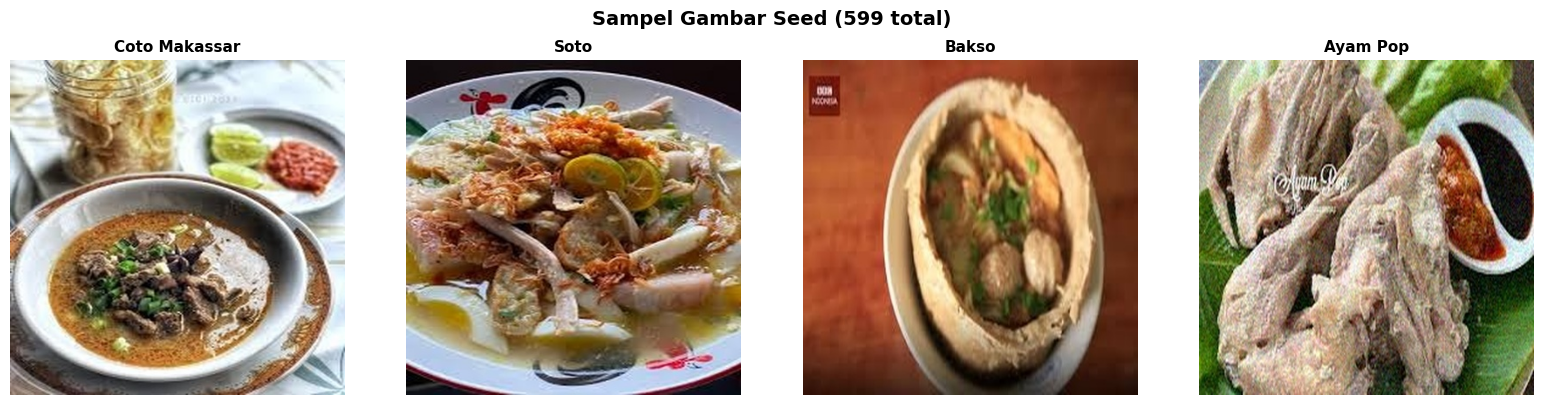

Ayam Bakar       40
Ayam Betutu      40
Ayam Goreng      38
Ayam Pop         39
Bakso            39
Coto Makassar    39
Gado Gado        37
Gudeg            47
Nasi Goreng      39
Pempek           37
Rawon            47
Rendang          39
Sate Madura      40
Sate Padang      39
Soto             39


In [37]:
def show_seed_samples(num_samples=16):
    sample_indices = np.random.choice(len(seed_idx), min(num_samples, len(seed_idx)), replace=False)
    
    n_cols = 4
    n_rows = (len(sample_indices) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, sample_idx in enumerate(sample_indices):
        global_idx = seed_idx[sample_idx]
        img_path = Path(CFG.CLEAN_DIR) / NAMES[global_idx]
        label = id2cls[y_seed[sample_idx]]
        
        try:
            img = Image.open(img_path).convert('RGB')
            axes[idx].imshow(img)
            axes[idx].set_title(f'{label}', fontweight='bold', fontsize=11)
            axes[idx].axis('off')
        except:
            axes[idx].text(0.5, 0.5, 'Error loading\nimage', 
                           ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'{label} (Error)', fontweight='bold', fontsize=11)
            axes[idx].axis('off')
    
    for idx in range(len(sample_indices), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Sampel Gambar Seed ({len(seed_idx)} total)', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    
    seed_labels = [id2cls[y] for y in y_seed]
    seed_dist = pd.Series(seed_labels).value_counts().sort_index()
    print(seed_dist.to_string())

show_seed_samples(num_samples=4)


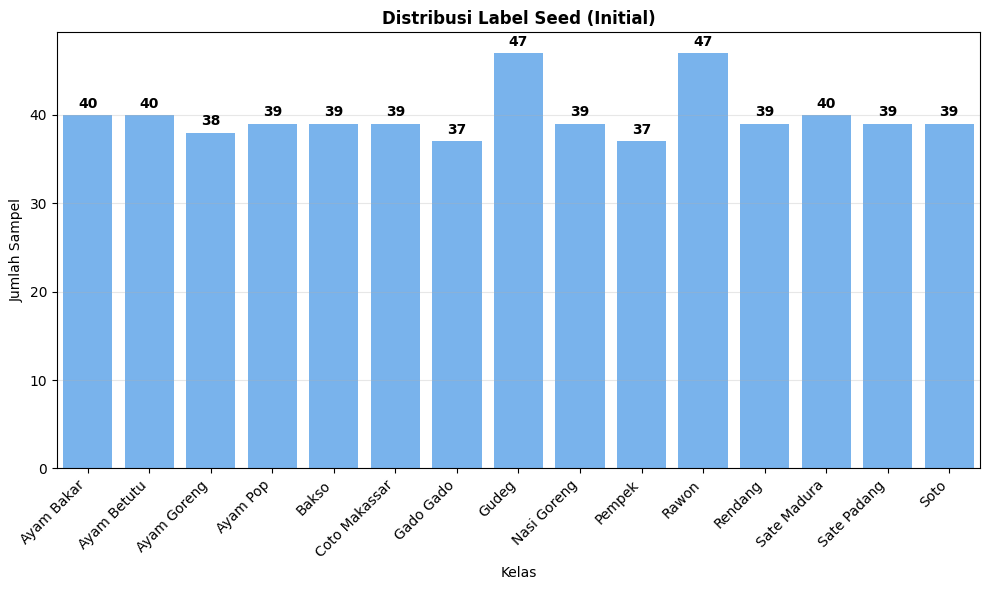


Total sampel seed: 599
Jumlah kelas: 15
Rata-rata sampel per kelas: 39.9
Min: 37 | Max: 47


In [38]:
def visualize_seed_distribution():
    seed_labels = [id2cls[y] for y in y_seed]
    seed_counts = pd.Series(seed_labels).value_counts().sort_index()
    
    df_seed = pd.DataFrame({
        'Class': seed_counts.index,
        'Count': seed_counts.values
    })
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_seed, x='Class', y='Count', color='#66b3ff')
    plt.title('Distribusi Label Seed (Initial)', fontweight='bold')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Sampel')
    plt.xticks(rotation=45, ha='right')
    
    for i, row in df_seed.iterrows():
        plt.text(i, row['Count'] + 0.5, str(row['Count']),
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal sampel seed: {len(y_seed)}")
    print(f"Jumlah kelas: {len(seed_counts)}")
    print(f"Rata-rata sampel per kelas: {seed_counts.mean():.1f}")
    print(f"Min: {seed_counts.min()} | Max: {seed_counts.max()}")

visualize_seed_distribution()


# SECTION 5: Model Architecture

---

In [39]:
class SELite(nn.Module):
    def __init__(self, dim, reduction=8):
        super().__init__()
        reduced = max(dim // reduction, 4)
        self.fc = nn.Sequential(
            nn.Linear(dim, reduced),
            nn.GELU(),
            nn.Linear(reduced, dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        attn = self.fc(x)
        return x * attn

class ResidualFFN(nn.Module):
    def __init__(self, dim, mult=2.0, p=0.25):
        super().__init__()
        hid = int(dim * mult)
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hid),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(hid, dim),
            nn.Dropout(p * 0.5)
        )
    def forward(self, x): return x + self.net(x)

class ImprovedLightweightMLP(nn.Module):
    def __init__(self, input_dim=1152, num_classes=15, p=0.25):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(input_dim, 768),
            nn.LayerNorm(768),
            nn.GELU(),
            nn.Dropout(p * 0.6),
        )
        self.se1 = SELite(768)
        self.block1 = ResidualFFN(768, mult=2.2, p=p)
        self.trans1 = nn.Sequential(
            nn.LayerNorm(768),
            nn.GELU(),
            nn.Dropout(p * 0.5),
            nn.Linear(768, 512)
        )

        self.se2 = SELite(512)
        self.block2 = ResidualFFN(512, mult=2.0, p=p)
        self.trans2 = nn.Sequential(
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(p * 0.4),
            nn.Linear(512, 256)
        )

        self.se3 = SELite(256)
        self.block3 = ResidualFFN(256, mult=1.8, p=p * 0.8)
        self.head = nn.Linear(256, num_classes)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None: nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        x = self.proj(x)
        x = self.se1(x)
        x = self.block1(x)
        x = self.trans1(x)
        x = self.se2(x)
        x = self.block2(x)
        x = self.trans2(x)
        x = self.se3(x)
        x = self.block3(x)
        return self.head(x)

# Hitung parameter
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_test = ImprovedLightweightMLP(input_dim=INPUT_DIM, num_classes=len(classes))
print(f"Improved MLP: {count_params(model_test):,} params (~{count_params(model_test)/1e3:.1f}K)")

Improved MLP: 5,535,796 params (~5535.8K)


# SECTION 6: Training System

---

In [40]:
class Trainer:
    def __init__(self, model, lr, weight=None, epochs=1):
        self.model = model.to(CFG.DEVICE)
        self.crit = nn.CrossEntropyLoss(weight=weight, label_smoothing=CFG.LABEL_SMOOTH)
        self.opt = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-4)
        self.epochs = epochs
        self.best_state = None
        self.best_acc = 0.0
        self.patience = 0
        self.total_steps = None
        self.warmup_steps = None
        self._step = 0
        
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': []
        }

    def _lr_schedule(self):
        if self._step < self.warmup_steps:
            scale = self._step / self.warmup_steps
        else:
            progress = (self._step - self.warmup_steps) / (self.total_steps - self.warmup_steps)
            scale = 0.5 * (1 + np.cos(np.pi * progress))
        for pg in self.opt.param_groups:
            pg['lr'] = pg.get('initial_lr', pg['lr']) * scale

    def fit_epoch(self, loader, train=True):
        self.model.train() if train else self.model.eval()
        total, correct, loss_sum = 0, 0, 0.0
        with torch.set_grad_enabled(train):
            for xb, yb in loader:
                xb, yb = xb.to(CFG.DEVICE), yb.to(CFG.DEVICE)
                if train: self.opt.zero_grad()
                logits = self.model(xb)
                loss = self.crit(logits, yb)
                if train:
                    loss.backward()
                    self._lr_schedule()
                    self.opt.step()
                    self._step += 1
                loss_sum += loss.item() * xb.size(0)
                correct += (logits.argmax(1) == yb).sum().item()
                total += xb.size(0)
        return loss_sum/total, correct/total

    def train(self, X, y, epochs, val_split=0.15):
        idx = np.arange(len(X))
        tr_idx, val_idx = train_test_split(idx, test_size=val_split, stratify=y, random_state=CFG.SEED)
        tr_dl = DataLoader(TensorDataset(torch.from_numpy(X[tr_idx]).float(), torch.from_numpy(y[tr_idx]).long()),
                           batch_size=CFG.BATCH, shuffle=True, pin_memory=True)
        val_dl = DataLoader(TensorDataset(torch.from_numpy(X[val_idx]).float(), torch.from_numpy(y[val_idx]).long()),
                            batch_size=CFG.BATCH, pin_memory=True)
       
        steps_per_epoch = len(tr_dl)
        self.total_steps = steps_per_epoch * epochs
        self.warmup_steps = max(1, int(self.total_steps * 0.1))
        for pg in self.opt.param_groups: pg['initial_lr'] = pg['lr']
        
        for ep in range(1, epochs+1):
            tr_loss, tr_acc = self.fit_epoch(tr_dl, train=True)
            val_loss, val_acc = self.fit_epoch(val_dl, train=False)

            self.history['train_loss'].append(tr_loss)
            self.history['train_acc'].append(tr_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            if val_acc > self.best_acc:
                self.best_acc = val_acc
                self.best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
                self.patience = 0
            else:
                self.patience += 1
            print(f"Ep {ep:02d} | TrAcc: {tr_acc:.4f} | ValAcc: {val_acc:.4f} | Best: {self.best_acc:.4f}")
            if self.patience >= CFG.EARLY_STOP_PATIENCE:
                print("Early stopping!")
                break
        if self.best_state:
            self.model.load_state_dict({k: v.to(CFG.DEVICE) for k, v in self.best_state.items()})
        return self.model

def get_weights(y):
    w = compute_class_weight('balanced', classes=np.unique(y), y=y)
    w = torch.FloatTensor(w).to(CFG.DEVICE)
    for c, mult in CFG.WEAK_CLASSES_V2.items():
        if c in cls2id:
            i = cls2id[c]
            w[i] *= mult
    return w / w.mean()

# SECTION 7: Semi-Supervised Learning (Self-Training)

---

In [41]:
def safe_pseudo_labeling(model, unlabeled_global_idx, features, threshold, max_per_class=250):
    """
    Properly handle index mapping during pseudo-labeling
    Returns: (selected_global_idx, selected_labels, remaining_global_idx)
    """
    model.eval()
    
    with torch.no_grad():
        probs_list = []
        for i in range(0, len(unlabeled_global_idx), CFG.BATCH):
            batch_idx = unlabeled_global_idx[i:i+CFG.BATCH]
            batch_features = torch.from_numpy(features[batch_idx]).float().to(CFG.DEVICE)
            logits = model(batch_features)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            probs_list.append(probs)
        
        probs = np.concatenate(probs_list)
    
    conf = probs.max(1)
    pred = probs.argmax(1)
    
    selected_local_indices = []
    
    num_classes = probs.shape[1]
    
    for class_id in range(num_classes):
        class_mask = (pred == class_id) & (conf >= threshold)
        class_indices = np.where(class_mask)[0]
        
        if len(class_indices) > 0:
            sorted_indices = class_indices[np.argsort(-conf[class_indices])]
            selected = sorted_indices[:min(len(sorted_indices), max_per_class)]
            selected_local_indices.extend(selected.tolist())
    
    selected_local_indices = np.array(selected_local_indices)
    
    if len(selected_local_indices) == 0:
        return np.array([]), np.array([]), unlabeled_global_idx
    
    selected_global_idx = unlabeled_global_idx[selected_local_indices]
    selected_labels = pred[selected_local_indices]
    
    mask = np.ones(len(unlabeled_global_idx), dtype=bool)
    mask[selected_local_indices] = False
    remaining_global_idx = unlabeled_global_idx[mask]
    
    return selected_global_idx, selected_labels, remaining_global_idx

In [42]:
all_idx = np.arange(len(NAMES))
seed_set = set(seed_idx)
unlabeled_idx = np.array([i for i in all_idx if i not in seed_set])

print("\nINITIAL TRAINING")
weights = get_weights(y_seed).to(CFG.DEVICE)
model = ImprovedLightweightMLP(input_dim=INPUT_DIM, num_classes=len(classes), p=CFG.DROPOUT)
trainer = Trainer(model, lr=CFG.PSEUDO_LR, weight=weights)
model = trainer.train(X_seed, y_seed, epochs=CFG.PSEUDO_EPOCHS)

model.eval()
with torch.no_grad():
    acc = (model(torch.from_numpy(X_seed).float().to(CFG.DEVICE)).argmax(1).cpu() == torch.from_numpy(y_seed)).float().mean()
    print(f"Seed accuracy: {acc:.4f}")

X_lab, y_lab = X_seed.copy(), y_seed.copy()
current_thresh = CFG.CONF_THRESH
unlabeled_global = unlabeled_idx.copy()


INITIAL TRAINING
Ep 01 | TrAcc: 0.1356 | ValAcc: 0.6556 | Best: 0.6556
Ep 02 | TrAcc: 0.5560 | ValAcc: 0.6111 | Best: 0.6556
Ep 03 | TrAcc: 0.7191 | ValAcc: 0.8000 | Best: 0.8000
Ep 04 | TrAcc: 0.9057 | ValAcc: 0.8556 | Best: 0.8556
Ep 05 | TrAcc: 0.9686 | ValAcc: 0.9444 | Best: 0.9444
Ep 06 | TrAcc: 0.9823 | ValAcc: 0.9222 | Best: 0.9444
Ep 07 | TrAcc: 0.9902 | ValAcc: 0.9333 | Best: 0.9444
Ep 08 | TrAcc: 0.9941 | ValAcc: 0.9222 | Best: 0.9444
Ep 09 | TrAcc: 1.0000 | ValAcc: 0.9333 | Best: 0.9444
Ep 10 | TrAcc: 0.9980 | ValAcc: 0.9444 | Best: 0.9444
Ep 11 | TrAcc: 1.0000 | ValAcc: 0.9444 | Best: 0.9444
Ep 12 | TrAcc: 1.0000 | ValAcc: 0.9444 | Best: 0.9444
Ep 13 | TrAcc: 1.0000 | ValAcc: 0.9444 | Best: 0.9444
Early stopping!
Seed accuracy: 0.9816


In [43]:
auto_labels_list = []

for rnd in range(3):
    print(f"\nSELF-TRAINING ROUND {rnd+1}/3")
    added = 0
    local_thresh = current_thresh
    max_attempts = 10
    attempts = 0

    while added < 35 and local_thresh >= CFG.MIN_CONF_THRESH and attempts < max_attempts:
        attempts += 1
        
        selected_global, selected_labels, remaining_global = safe_pseudo_labeling(
            model, unlabeled_global, FEATS, local_thresh, CFG.MAX_PER_CLASS
        )
        
        added = len(selected_global)
        print(f"  Attempt {attempts}: Thresh {local_thresh:.3f} → {added} samples")
        
        if added >= 35:
            for idx, label in zip(selected_global, selected_labels):
                auto_labels_list.append({
                    'file_name': NAMES[idx],
                    'pred_class': id2cls[label],
                    'confidence': float(local_thresh),  
                    'accepted': True,
                    'method': f'self_training_round_{rnd+1}'
                })
            
            X_lab = np.vstack([X_lab, FEATS[selected_global]])
            y_lab = np.concatenate([y_lab, selected_labels])
            unlabeled_global = remaining_global
            
            print(f"  Added: {added} | Total labeled: {len(X_lab)}")
            
            weights = get_weights(y_lab).to(CFG.DEVICE)
            model = ImprovedLightweightMLP(input_dim=INPUT_DIM, num_classes=len(classes), p=CFG.DROPOUT)
            trainer = Trainer(model, lr=CFG.PSEUDO_LR * 0.75, weight=weights)
            model = trainer.train(X_lab, y_lab, epochs=10)
            cleanup()
            break
        
        if added <= 10 and attempts >= 3:
            print(f"  Stuck at {added} samples, stopping early")
            break
            
        local_thresh = max(CFG.MIN_CONF_THRESH, local_thresh - 0.04)
    
    if added == 0:
        print("No pseudo-labels found. Stopping self-training.")
        break
    
    current_thresh = max(CFG.MIN_CONF_THRESH, current_thresh - 0.03)

if auto_labels_list:
    df_auto = pd.DataFrame(auto_labels_list)
    df_auto.to_csv(CFG.AUTO_LABEL_CSV, index=False)
    print(f"\n✅ Auto labels saved: {CFG.AUTO_LABEL_CSV}")
    print(f"Total pseudo-labeled samples: {len(df_auto)}")


SELF-TRAINING ROUND 1/3
  Attempt 1: Thresh 0.920 → 2130 samples
  Added: 2130 | Total labeled: 2729
Ep 01 | TrAcc: 0.3812 | ValAcc: 0.6780 | Best: 0.6780
Ep 02 | TrAcc: 0.9107 | ValAcc: 0.9805 | Best: 0.9805
Ep 03 | TrAcc: 0.9879 | ValAcc: 0.9902 | Best: 0.9902
Ep 04 | TrAcc: 0.9940 | ValAcc: 0.9902 | Best: 0.9902
Ep 05 | TrAcc: 0.9953 | ValAcc: 0.9829 | Best: 0.9902
Ep 06 | TrAcc: 0.9944 | ValAcc: 0.9878 | Best: 0.9902
Ep 07 | TrAcc: 0.9983 | ValAcc: 0.9878 | Best: 0.9902
Ep 08 | TrAcc: 0.9996 | ValAcc: 0.9902 | Best: 0.9902
Ep 09 | TrAcc: 0.9996 | ValAcc: 0.9902 | Best: 0.9902
Ep 10 | TrAcc: 0.9996 | ValAcc: 0.9902 | Best: 0.9902

SELF-TRAINING ROUND 2/3
  Attempt 1: Thresh 0.890 → 849 samples
  Added: 849 | Total labeled: 3578
Ep 01 | TrAcc: 0.4110 | ValAcc: 0.8752 | Best: 0.8752
Ep 02 | TrAcc: 0.9339 | ValAcc: 0.9702 | Best: 0.9702
Ep 03 | TrAcc: 0.9763 | ValAcc: 0.9721 | Best: 0.9721
Ep 04 | TrAcc: 0.9915 | ValAcc: 0.9777 | Best: 0.9777
Ep 05 | TrAcc: 0.9934 | ValAcc: 0.9795 | B

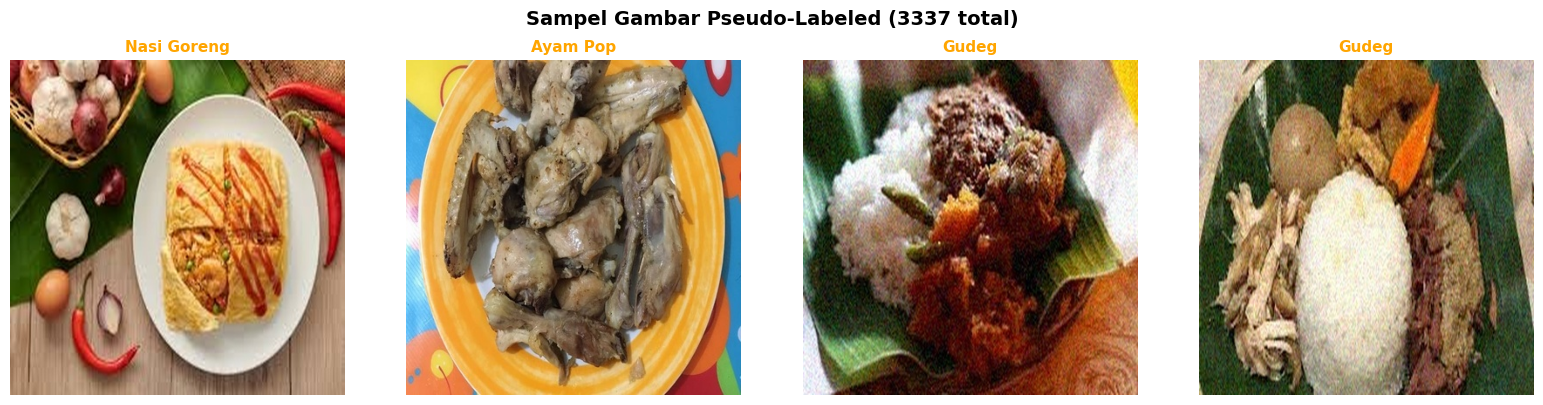


Distribusi Pseudo-Labels:
Ayam Bakar       213
Ayam Betutu      198
Ayam Goreng      269
Ayam Pop         199
Bakso            232
Coto Makassar    219
Gado Gado        215
Gudeg            202
Nasi Goreng      250
Pempek           231
Rawon            193
Rendang          202
Sate Madura      222
Sate Padang      255
Soto             237


In [44]:
def show_pseudo_samples(num_samples=16):
    """Tampilkan beberapa sampel gambar pseudo-labeled beserta labelnya"""
    
    if len(auto_labels_list) == 0:
        print("Tidak ada pseudo-labels untuk ditampilkan")
        return
    
    sample_indices = np.random.choice(len(auto_labels_list), min(num_samples, len(auto_labels_list)), replace=False)
    
    n_cols = 4
    n_rows = (len(sample_indices) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, sample_idx in enumerate(sample_indices):
        auto_label = auto_labels_list[sample_idx]
        file_name = auto_label['file_name']
        label = auto_label['pred_class']
        
        img_path = Path(CFG.CLEAN_DIR) / file_name
        
        try:
            img = Image.open(img_path).convert('RGB')
            axes[idx].imshow(img)
            axes[idx].set_title(f'{label}', fontweight='bold', fontsize=11, color='orange')
            axes[idx].axis('off')
        except:
            axes[idx].text(0.5, 0.5, 'Error loading\nimage', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'{label} (Error)', fontweight='bold', fontsize=11, color='orange')
            axes[idx].axis('off')
    
    for idx in range(len(sample_indices), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Sampel Gambar Pseudo-Labeled ({len(auto_labels_list)} total)', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    
    pseudo_labels = [item['pred_class'] for item in auto_labels_list]
    pseudo_dist = pd.Series(pseudo_labels).value_counts().sort_index()
    print(f"\nDistribusi Pseudo-Labels:")
    print(pseudo_dist.to_string())

show_pseudo_samples(num_samples=4)


Label Awal: 599 sampel
Label Akhir: 3936 sampel (+3337 pseudo-labels)
Kelas unik: 15


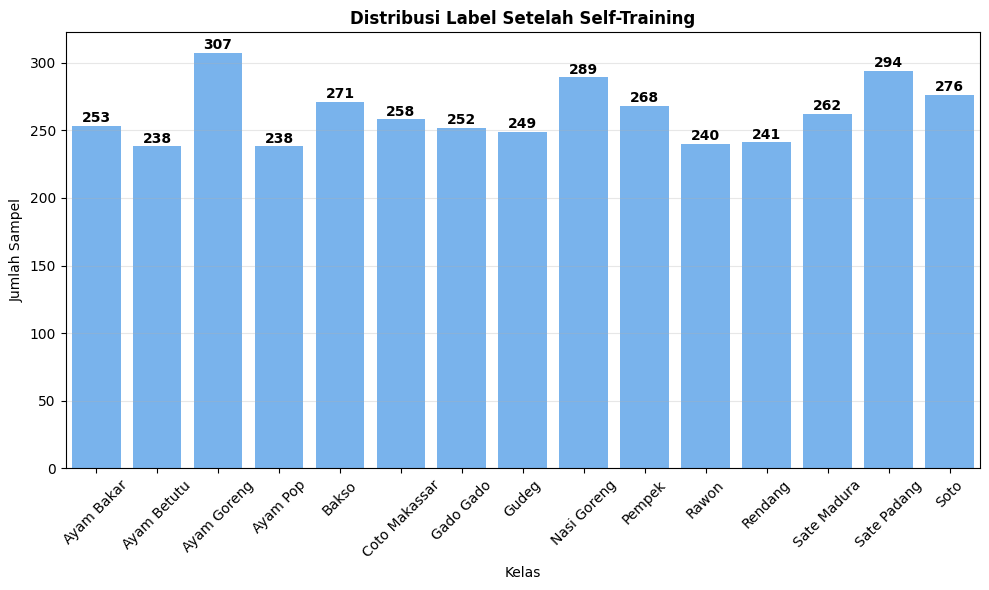


Total sampel setelah self-training: 3936
Jumlah kelas: 15


In [45]:
initial_labels = [id2cls[y] for y in y_seed]
final_labels = [id2cls[y] for y in y_lab]

print(f"\nLabel Awal: {len(y_seed)} sampel")
print(f"Label Akhir: {len(y_lab)} sampel (+{len(y_lab)-len(y_seed)} pseudo-labels)")
print(f"Kelas unik: {len(np.unique(y_lab))}")

final_counts = pd.Series(final_labels).value_counts().sort_index()

df_final = pd.DataFrame({
    'Class': final_counts.index,
    'Count': final_counts.values
})

plt.figure(figsize=(10, 6))
sns.barplot(data=df_final, x='Class', y='Count', color='#66b3ff')
plt.title('Distribusi Label Setelah Self-Training', fontweight='bold')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45)

for i, row in df_final.iterrows():
    plt.text(i, row['Count'] + 0.5, str(row['Count']),
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal sampel setelah self-training: {len(y_lab)}")
print(f"Jumlah kelas: {len(final_counts)}")

# SECTION 8: Final Training

---


FINAL TRAINING
Ep 01 | TrAcc: 0.2933 | ValAcc: 0.6717 | Best: 0.6717
Ep 02 | TrAcc: 0.8347 | ValAcc: 0.9442 | Best: 0.9442
Ep 03 | TrAcc: 0.9501 | ValAcc: 0.9391 | Best: 0.9442
Ep 04 | TrAcc: 0.9638 | ValAcc: 0.9611 | Best: 0.9611
Ep 05 | TrAcc: 0.9632 | ValAcc: 0.9357 | Best: 0.9611
Ep 06 | TrAcc: 0.9692 | ValAcc: 0.9340 | Best: 0.9611
Ep 07 | TrAcc: 0.9800 | ValAcc: 0.9594 | Best: 0.9611
Ep 08 | TrAcc: 0.9877 | ValAcc: 0.9662 | Best: 0.9662
Ep 09 | TrAcc: 0.9859 | ValAcc: 0.9560 | Best: 0.9662
Ep 10 | TrAcc: 0.9880 | ValAcc: 0.9645 | Best: 0.9662
Ep 11 | TrAcc: 0.9886 | ValAcc: 0.9526 | Best: 0.9662
Ep 12 | TrAcc: 0.9898 | ValAcc: 0.9594 | Best: 0.9662
Ep 13 | TrAcc: 0.9928 | ValAcc: 0.9628 | Best: 0.9662
Ep 14 | TrAcc: 0.9922 | ValAcc: 0.9662 | Best: 0.9662
Ep 15 | TrAcc: 0.9913 | ValAcc: 0.9526 | Best: 0.9662
Ep 16 | TrAcc: 0.9964 | ValAcc: 0.9679 | Best: 0.9679
Ep 17 | TrAcc: 0.9961 | ValAcc: 0.9577 | Best: 0.9679
Ep 18 | TrAcc: 0.9976 | ValAcc: 0.9577 | Best: 0.9679
Ep 19 | TrAc

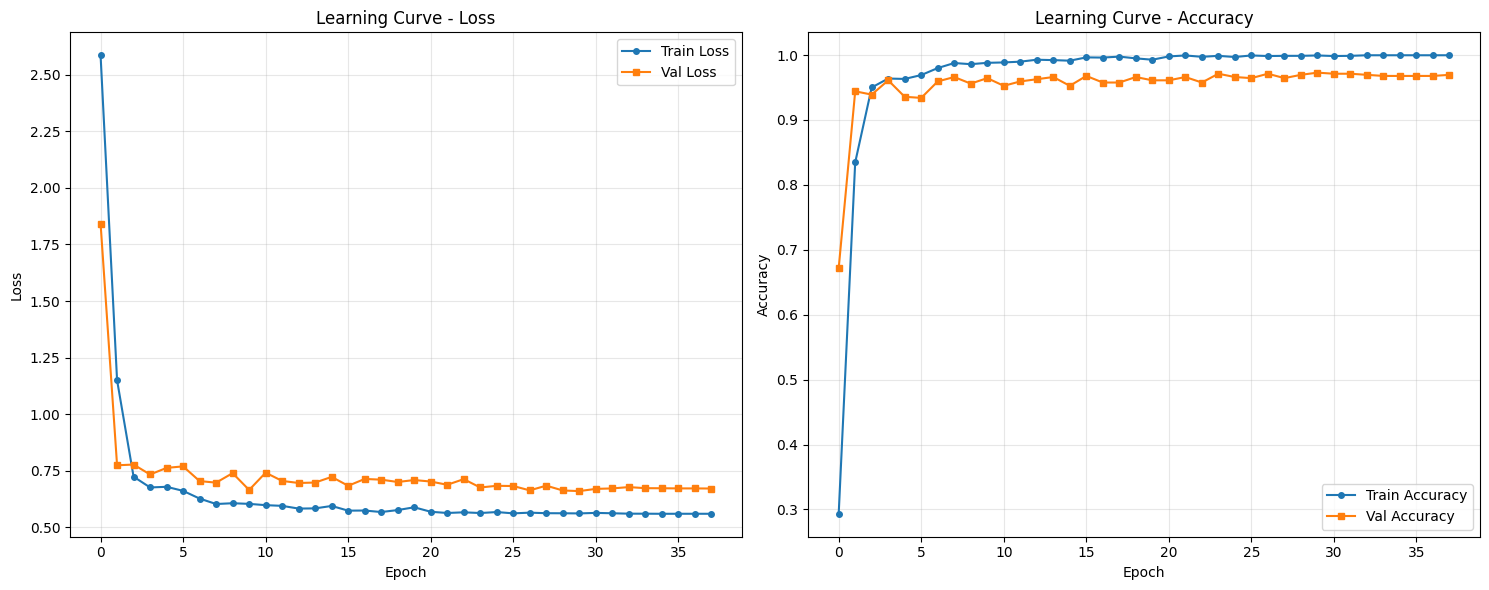

In [46]:
print("\n" + "="*60)
print("FINAL TRAINING")
print("="*60)
final_model = ImprovedLightweightMLP(input_dim=INPUT_DIM, num_classes=len(classes), p=CFG.DROPOUT)
weights = get_weights(y_lab).to(CFG.DEVICE)
trainer = Trainer(final_model, lr=CFG.LR, weight=weights, epochs=CFG.EPOCHS)
final_model = trainer.train(X_lab, y_lab, epochs=CFG.EPOCHS)
# Save model and metadata
torch.save(final_model.state_dict(), os.path.join(CFG.WORKDIR, "final_mlp_improved.pth"))
pickle.dump({"cls2id": cls2id, "id2cls": id2cls, "FE_mean": FE_mean, "FE_std": FE_std},
            open(os.path.join(CFG.WORKDIR, "meta.pkl"), "wb"))


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(trainer.history['train_loss'], label='Train Loss', marker='o', markersize=4)
plt.plot(trainer.history['val_loss'], label='Val Loss', marker='s', markersize=4)
plt.title('Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(trainer.history['train_acc'], label='Train Accuracy', marker='o', markersize=4)
plt.plot(trainer.history['val_acc'], label='Val Accuracy', marker='s', markersize=4)
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


EVALUATION METRICS

Validation Accuracy: 0.9729
Macro F1-Score: 0.9727
Weighted F1-Score: 0.9730

------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
               precision    recall  f1-score   support

   Ayam Bakar     0.9000    0.9474    0.9231        38
  Ayam Betutu     0.9697    0.8889    0.9275        36
  Ayam Goreng     0.9362    0.9565    0.9462        46
     Ayam Pop     0.9730    1.0000    0.9863        36
        Bakso     0.9535    1.0000    0.9762        41
Coto Makassar     1.0000    0.9487    0.9737        39
    Gado Gado     1.0000    1.0000    1.0000        38
        Gudeg     0.9730    0.9730    0.9730        37
  Nasi Goreng     1.0000    1.0000    1.0000        43
       Pempek     1.0000    0.9750    0.9873        40
        Rawon     0.9231    1.0000    0.9600        36
      Rendang     1.0000    0.9722    0.9859        36
  Sate Madura     0.9744    0.9744    0.9

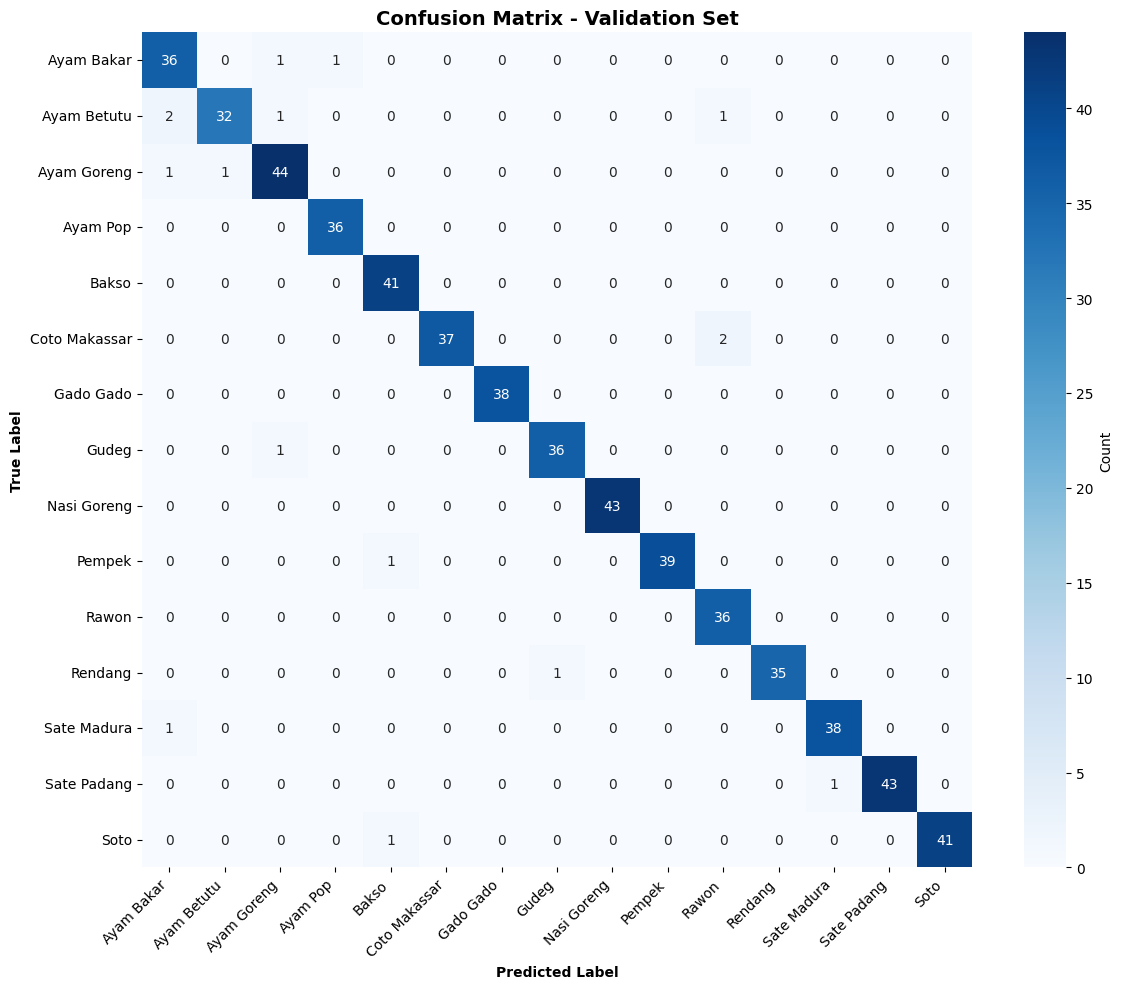

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

print("\n" + "="*60)
print("EVALUATION METRICS")
print("="*60)

idx = np.arange(len(X_lab))
tr_idx, val_idx = train_test_split(idx, test_size=0.15, stratify=y_lab, random_state=CFG.SEED)

X_val = X_lab[val_idx]
y_val = y_lab[val_idx]

final_model.eval()
with torch.no_grad():
    val_logits = final_model(torch.from_numpy(X_val).float().to(CFG.DEVICE))
    y_pred = val_logits.argmax(1).cpu().numpy()

val_acc = accuracy_score(y_val, y_pred)
val_f1_macro = f1_score(y_val, y_pred, average='macro')
val_f1_weighted = f1_score(y_val, y_pred, average='weighted')

print(f"\nValidation Accuracy: {val_acc:.4f}")
print(f"Macro F1-Score: {val_f1_macro:.4f}")
print(f"Weighted F1-Score: {val_f1_weighted:.4f}")

print("\n" + "-"*60)
print("CLASSIFICATION REPORT")
print("-"*60)
print(classification_report(y_val, y_pred, target_names=classes, digits=4))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Validation Set', fontweight='bold', fontsize=14)
plt.xlabel('Predicted Label', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# SECTION 9: Inference & Submission

---

## 9.1 Advanced Test-Time Augmentation

In [47]:
class AdvancedTTA:
    """
    Advanced Test-Time Augmentation with multiple strategies:
    1. Feature dropout
    2. Adaptive noise based on feature statistics
    3. Feature mixing with nearest neighbors
    4. Weighted ensemble based on prediction confidence
    """
    
    def __init__(self, n_augments=10, dropout_rate=0.1, noise_scale=0.05, mix_alpha=0.1):
        self.n_augments = n_augments
        self.dropout_rate = dropout_rate
        self.noise_scale = noise_scale
        self.mix_alpha = mix_alpha
    
    def apply_feature_dropout(self, features):
        """Randomly drop features to simulate uncertainty"""
        mask = np.random.binomial(1, 1 - self.dropout_rate, size=features.shape).astype(np.float32)
        aug_features = features * mask
        aug_features = aug_features / (1 - self.dropout_rate + 1e-6)
        return aug_features
    
    def apply_adaptive_noise(self, features):
        """Add noise scaled by feature variance"""
        feature_std = np.std(features, axis=0, keepdims=True) + 1e-6
        
        noise = np.random.randn(*features.shape).astype(np.float32)
        noise = noise * feature_std * self.noise_scale
        
        aug_features = features + noise
        return aug_features
    
    def apply_feature_mixing(self, features):
        """Mix features with random neighbors"""
        n_samples = len(features)
        
        idx = np.random.permutation(n_samples)
        
        aug_features = (1 - self.mix_alpha) * features + self.mix_alpha * features[idx]
        
        return aug_features
    
    def apply_channel_shuffle(self, features):
        """Randomly shuffle feature channels in groups"""
        n_features = features.shape[1]
        group_size = max(1, n_features // 8) 
        
        aug_features = features.copy()
        
        for i in range(0, n_features, group_size):
            end_idx = min(i + group_size, n_features)
            group_indices = np.arange(i, end_idx)
            np.random.shuffle(group_indices)
            aug_features[:, i:end_idx] = features[:, group_indices]
        
        return aug_features
    
    def predict(self, model, features, batch_size=64):
        """
        Generate predictions with multiple augmentation strategies
        Returns: Weighted ensemble predictions
        """
        model.eval()
        predictions = []
        confidences = []
        
        print(f"\n🔄 Advanced TTA with {self.n_augments} augmentations...")
        
        with torch.no_grad():
            orig_probs = self._batch_predict(model, features, batch_size)
            predictions.append(orig_probs)
            confidences.append(np.max(orig_probs, axis=1).mean())
            
            for aug_idx in range(self.n_augments - 1):
                aug_features = features.copy()
                
                strategy = aug_idx % 4
                
                if strategy == 0:
                    aug_features = self.apply_feature_dropout(aug_features)
                    aug_name = "dropout"
                elif strategy == 1:
                    aug_features = self.apply_adaptive_noise(aug_features)
                    aug_name = "noise"
                elif strategy == 2:
                    aug_features = self.apply_feature_mixing(aug_features)
                    aug_name = "mixing"
                else:
                    aug_features = self.apply_channel_shuffle(aug_features)
                    aug_name = "shuffle"
                
                aug_features = aug_features / (np.linalg.norm(aug_features, axis=1, keepdims=True) + 1e-6)

                aug_probs = self._batch_predict(model, aug_features, batch_size)
                predictions.append(aug_probs)
                

                conf = np.max(aug_probs, axis=1).mean()
                confidences.append(conf)
                
                if (aug_idx + 1) % 3 == 0:
                    print(f"  Augmentation {aug_idx + 2}/{self.n_augments} ({aug_name}) - Conf: {conf:.4f}")
        

        confidences = np.array(confidences)
        

        weights = np.exp(confidences * 2)  
        weights = weights / weights.sum()
        
        print(f"\n📊 Augmentation weights (confidence-based):")
        print(f"  Original: {weights[0]:.3f}")
        for i in range(1, min(5, len(weights))):
            print(f"  Aug {i}: {weights[i]:.3f}")
        

        final_predictions = np.zeros_like(predictions[0])
        for pred, weight in zip(predictions, weights):
            final_predictions += pred * weight
        
        print(f"\n✅ Advanced TTA complete with weighted ensemble")
        
        return final_predictions
    
    def _batch_predict(self, model, features, batch_size):
        """Helper function for batch prediction"""
        n_samples = len(features)
        probs_list = []
        
        for i in range(0, n_samples, batch_size):
            batch = features[i:i+batch_size]
            batch_tensor = torch.from_numpy(batch).float().to(CFG.DEVICE)
            
            logits = model(batch_tensor)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            probs_list.append(probs)
        
        return np.concatenate(probs_list)

## 9.2 Run Inference with TTA

In [48]:
print(f"\n{'='*60}")
print(f"INFERENCE WITH ADVANCED TEST-TIME AUGMENTATION")
print(f"{'='*60}")

X_test, test_names = extract_features_from_dir(CFG.TEST_DIR, train=False)
print(f"✅ Test features extracted: {X_test.shape}")

X_test_normalized = (X_test.astype(np.float32) - FE_mean) / FE_std
X_test_normalized /= np.linalg.norm(X_test_normalized, axis=1, keepdims=True) + 1e-6

tta = AdvancedTTA(
    n_augments=12,      
    dropout_rate=0.1,   
    noise_scale=0.03,   
    mix_alpha=0.15      
)

final_probs = tta.predict(final_model, X_test_normalized, batch_size=CFG.BATCH)

preds = [id2cls[i] for i in final_probs.argmax(1)]

confidence_scores = final_probs.max(axis=1)
print(f"\n📊 Prediction Confidence Analysis:")
print(f"  Mean confidence: {confidence_scores.mean():.4f}")
print(f"  Min confidence: {confidence_scores.min():.4f}")
print(f"  Max confidence: {confidence_scores.max():.4f}")
print(f"  Samples with conf > 0.9: {(confidence_scores > 0.9).sum()} ({(confidence_scores > 0.9).mean()*100:.1f}%)")
print(f"  Samples with conf < 0.5: {(confidence_scores < 0.5).sum()} ({(confidence_scores < 0.5).mean()*100:.1f}%)")

sub = pd.DataFrame({"ID": test_names, "label": preds})
sub["ID"] = sub["ID"].apply(lambda x: int(os.path.splitext(os.path.basename(x))[0]))
sub = sub.sort_values("ID").reset_index(drop=True)
sub.to_csv(CFG.SUBMISSION, index=False)

print(f"\n✅ Submission saved: {CFG.SUBMISSION}")
print(f"\n📊 Prediction distribution:")
print(sub["label"].value_counts())


INFERENCE WITH ADVANCED TEST-TIME AUGMENTATION
Loading cached features: /kaggle/working/test_feats_siglip384_norm.npz
✅ Test features extracted: (2057, 1152)

🔄 Advanced TTA with 12 augmentations...
  Augmentation 4/12 (mixing) - Conf: 0.9077
  Augmentation 7/12 (noise) - Conf: 0.9100
  Augmentation 10/12 (dropout) - Conf: 0.9096

📊 Augmentation weights (confidence-based):
  Original: 0.086
  Aug 1: 0.086
  Aug 2: 0.086
  Aug 3: 0.085
  Aug 4: 0.072

✅ Advanced TTA complete with weighted ensemble

📊 Prediction Confidence Analysis:
  Mean confidence: 0.7844
  Min confidence: 0.2447
  Max confidence: 0.9296
  Samples with conf > 0.9: 8 (0.4%)
  Samples with conf < 0.5: 15 (0.7%)

✅ Submission saved: /kaggle/working/submission.csv

📊 Prediction distribution:
label
Nasi Goreng      238
Ayam Goreng      221
Soto             188
Sate Madura      181
Sate Padang      158
Ayam Bakar       154
Bakso            153
Pempek           145
Coto Makassar    121
Gado Gado        109
Ayam Pop         

## 9.3 Create Submission File

In [49]:
sub = pd.DataFrame({"ID": test_names, "label": preds})
sub["ID"] = sub["ID"].apply(lambda x: int(os.path.splitext(os.path.basename(x))[0]))
sub = sub.sort_values("ID").reset_index(drop=True)
sub.to_csv(CFG.SUBMISSION, index=False)

print(f"\n✅ Submission saved: {CFG.SUBMISSION}")
print(f"\n📊 Prediction distribution:")
print(sub["label"].value_counts())


✅ Submission saved: /kaggle/working/submission.csv

📊 Prediction distribution:
label
Nasi Goreng      238
Ayam Goreng      221
Soto             188
Sate Madura      181
Sate Padang      158
Ayam Bakar       154
Bakso            153
Pempek           145
Coto Makassar    121
Gado Gado        109
Ayam Pop          89
Rendang           89
Rawon             82
Ayam Betutu       80
Gudeg             49
Name: count, dtype: int64


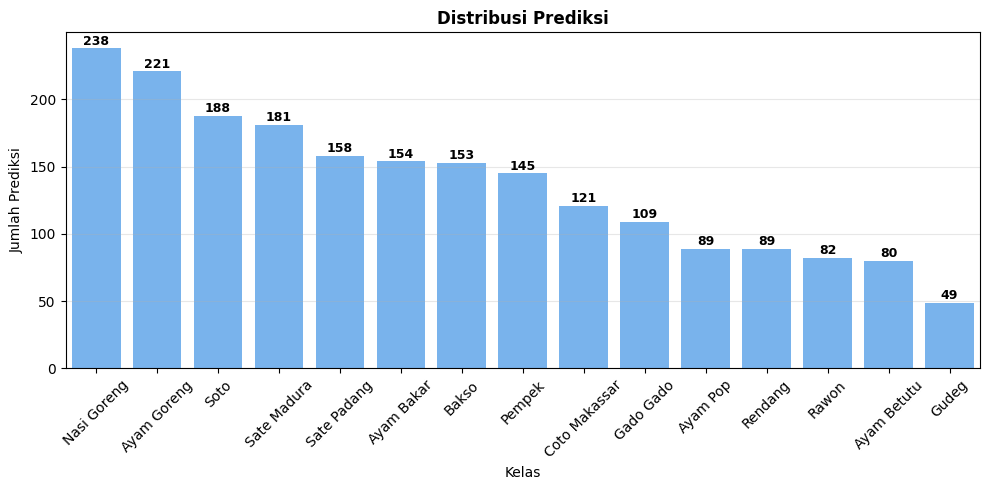

In [50]:
counts = sub["label"].value_counts().sort_values(ascending=False)
df_plot = pd.DataFrame({"Class": counts.index, "Count": counts.values})

plt.figure(figsize=(10, 5))
sns.barplot(data=df_plot, x="Class", y="Count", color="#66b3ff")
plt.title("Distribusi Prediksi", fontweight="bold")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Prediksi")
plt.xticks(rotation=45)

for i, row in df_plot.iterrows():
    plt.text(i, row["Count"] + 0.5, str(row["Count"]),
             ha="center", va="bottom", fontsize=9, fontweight="bold")

plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()